# wk7 Demo - Regularization & Gradient Descent con't
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

Last week we talked about optimization theory in the context of the supervised learning of a parametric model. Gradient descent allows us to find the model parameters that minimize a loss function, provided that the loss function is (pseudo) convex. Full batch GD is easy to parallelize, however the need to make many passes over the entire dataset is still a cost we'd like to minimize when processing large scale data. Today we'll dive a bit further into techniques for improving the training of supervised ML models. By the end of this live session you should be able to:
* __... explain__ why and how we regularize linear and logistic regression models.
* __... compare__ L1 and L2 regularization in terms of their effects on model parameters.
* __... identify__ a few common gradient descent variants.
* __... describe__ the numerical approximization method & when we might use it.


### Notebook Set-Up

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Regularization: what and how? 

In any supervised learning context we are concerned with making sure our trained models are going to generalize well to unseen data. Regularization techniques help us avoid overfitting. In general they boil down to strategicalling limiting the variance of a model so that we don't accidentally learn patterns in the noise of our data. As we learned early on this reduction in variance will come at the expense of a potential increase in bias. Early stopping is one of the most popular ways to do this but it requires that you are able to set aside a validation set which may not always be feasible, especially with very high dimensional data. Another strategy is to add a penalty term to the loss function when performing your gradient updates. In this section we'll return to the small example from last class to build some intuitions for what this looks like and how this works.

### Demo 1: Small example revisited

Run the provided code below to see how regularized and unregularized gradiet descent compare on our small example. Try changing the hyperparameters one at a time to explore their effects paying particular attention to both the path that the training takes and the location of the "final" model. Use the discussion questions below to help you draw some conclusions based on what you see.

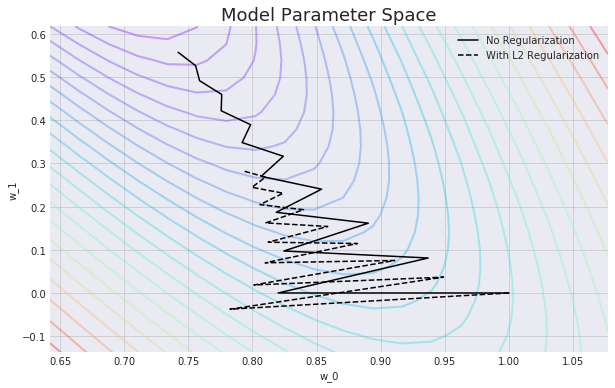

In [10]:
import helperFunc as hf

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
REGULARIZATION_PARAMETER = 0.25
LEARNING_RATE = 0.075
ORIGINAL_MODEL = [1,0]
N_STEPS = 15

################### Effect of Regularization Demo #################### 
### small example data
X = np.array([[1,1],[3,1],[5,1],[4,1],[2,1]])
y = np.array([2,3,4,3,3])
data_domain = [0,5]

### Unregularized Gradient descent training history
no_reg, _ = hf.GDUpdate(X, y, N_STEPS, ORIGINAL_MODEL, LEARNING_RATE)

### Regularized Gradient descent training history
w_reg, _ = hf.GDUpdate(X, y, N_STEPS, ORIGINAL_MODEL, LEARNING_RATE, 
                       reg_type = 'l2', reg_param = REGULARIZATION_PARAMETER)

### plot comparison
hf.compareDescent(X, y, no_reg, w_reg, labels=['No Regularization', 'With L2 Regularization'])

 > __DISCUSSION QUESTIONS:__  
 * _How does the regularized training path compare to the unregularized path?_
 * _How do the final regularized models compare to their unregularized counterparts? (Pay particular attention to the weight 0 parameter.) Does this change when you adjust the learning rate?_ 
 * _Given that regularization is something we do to improve the performance of our model does anything seem surprising about the loss where each training path ends?_
 * _How does the regularization parameter affect the training path? How does it affect the final model?_
 * Adjust the learning rate back up to accentuate the zig-zags... take a close look at the direction of the updates in the regularized training path. _Do these updates seem to be going 'down hill'? what conclusions can you draw about the relationship between the regularized model updates and the loss function? -- try to ground your discussion in what you see on the plot rather than theory from other sources._

__INSTRUCTOR TALKING POINTS__

Key Points:
* strategic modification to loss function (doesn't actully change error)
* early stopping = most common way to regularize (but how do you know when? also this makes you possibly vulnerable to where you start.)
* note effect of lambda
* note the shrinkage of w_0

 * _How does the regularized training path compare to the unregularized path?_
 > It seems to be a wider "zig zag". It stops farther uphill. The updates are not in the same direction as the OLS gradient updates.
 
 * _How do the final regularized models compare to their unregularized counterparts? (Pay particular attention to the weight 0 parameter.) Does this change when you adjust the learning rate?_ 
 > The are not at the optimum (they stop "up hill" of what seems like the ideal mode.). In particular the regularized path always seems to stop closer to the origin than the unregularized mode.
 
 * _Given that regularization is something we do to improve the performance of our model does anything seem surprising about the loss where each training path ends?_
 > The final model has a higher loss! (don't we want a lower loss <-- asked in a 'naive play acting voice').
 
 * _How does the regularization parameter affect the training path? How does it affect the final model?_
> 0 ---> no reg, same path

 * Adjust the learning rate back up to accentuate the zig-zags... take a close look at the direction of the updates in the regularized training path. _Do these updates seem to be going 'down hill'? what conclusions can you draw about the relationship between the regularized model updates and the loss function? -- try to ground your discussion in what you see on the plot rather than theory from other sources._
 > No, the regularized updates are not pointing down hill.. in fact they are consistently a little "shallower" in their direction than their non-regularized counterparts. That must mean the regularized model is either 1) choosing not to go downhill or 2) choosing specifically to go a different direction based on some different goal (<-- this is the lead in to point out that actually the regularized path _IS_ going downhill, just downhill on an entirely different surface.

### Demo 2: Penalizing the loss for our small example.

As you saw in the exercise above, the regularized gradient descent path doesn't exactly seem to follow the principle of taking steps "directly downhill." Under the hood, this is because the regularized training is performing updates based on gradients from a slightly different curve, called the _penalized loss function_ which will (by intention) have a different minimum (one that we think will be more generalizable to unseen data). 

Before diving in to why we think this, let's briefly review the two kinds of penalties commonly used in training linear models. As you saw in chapter 6 of Intro to Statistical Learning:
* __Ridge Regression__ adds an __l2__ penalty term to the OLS loss function:
$$\lambda\sum_{i=1}^m (w_{i})^2$$
* __LASSO Regression__ adds an __l1__ penalty term to the OLS loss function:
$$\lambda\sum_{i=1}^m |w_{i}|$$

Each of these penalty terms includes a hyperparameter, $\lambda$, which allows us to tune how strongly the penalty term changes the shape of the loss curve. It is important to note that by using this penalty term we aren't making a choice to measure _error_ differently, we are creating an entirely different equation to optimize instead. Also note that, unlike the loss function itself, the regularization term is _only_ a function of the weights (not including bias!) and does not depend on the data.

Run the code below to view these penalty terms plotted in 3D. Try changing the regularization parameter to see how this affects the curves (hint, due to autoscaling of the plots you'll need to look carefully at the axes for this). Finally, modify the `REG_TYPE` to see how the OLS loss curve in the second row changes when a penalty term is added.

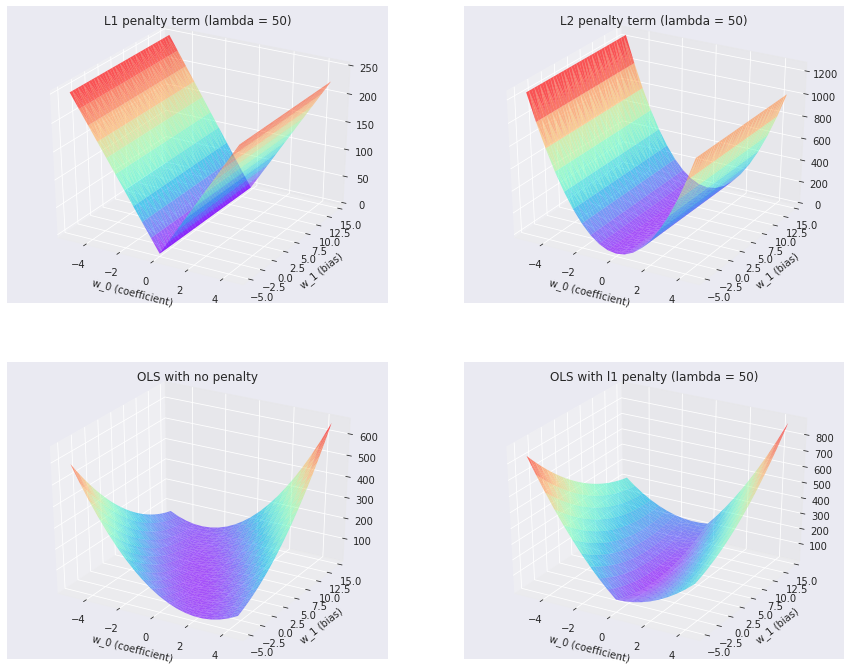

In [11]:
import helperFunc as hf

#################### Demo Parameters #################### 
# TRY CHANGING THESE & SEE HOW IT AFFECTS OUR SEARCH
REGULARIZATION_PARAMETER = 50
REG_TYPE = 'l1'  # try 'l1' or 'l2'

################### Penalized Loss Curves Demo #################### 
### small example data
X = np.array([[1,1],[3,1],[5,1],[4,1],[2,1]])
y = np.array([2,3,4,3,3])
data_domain = [0,5]

### set up the grid for the surface plots
grid = np.mgrid[-5:5:0.5,-5:15:0.5]
size = int(np.product(grid.shape)/2)
models_grid = grid.reshape(2,size)

### plot comparison
hf.compareLossCurves(X, y, reg_type = REG_TYPE, reg_param = REGULARIZATION_PARAMETER, grid = models_grid)

 > __DISCUSSION QUESTIONS:__  
 * _Compare the l1 and l2 penalty curves? Do they have a 'minimum' per se? How can we see in the graph that the regularization term doesn't depend on the bias value, only the coefficient?_
 * _Compare contrast the penalty terms to the OLS loss curve itself. (hint: pay careful attention to the z axis here)_
 * _How does the regularization parameter affect the shape of the penalty curves_
 * Predict what will happen to the OLS curve's shape if we add l1/l2 regularization. Then adjust the `REG_TYPE` to see it in action. Do the results match your expectation?
 * BONUS: what is the connection between these plots and Figure 6.7 on p222 of _Intro to Statistical Learning_.

__INSTRUCTOR TALKING POINTS__

 * _Compare the l1 and l2 penalty curves? Do they have a 'minimum' per se? How can we see in the graph that the regularization term doesn't depend on the bias value, only the coefficient?_
> No! minimum line not minimum point... the shape of the penalty term curves doesn't depend on the bias term (see how it is "flat" in that direction?)

* _Compare contrast the penalty terms to the OLS loss curve itself. (hint: pay careful attention to the z axis here)_
> the regularized model has higher loss values across the board (easiest to see at the edges, but most important that this is true for the minimum)... this should make sense, we're adding two positive terms the result will be higher than each one individually. (this is a good moment to pull out the 3D vis in grapher).

 * _How does the regularization parameter affect the shape of the penalty curves_
 > it shifts the "purple" minimum region from being diagonally oriented to seeming more oriented along the W_0=0 axis (look for a "crease" if using l1). This causes the minimum to be pulled towards w_0=0.
 
 * Predict what will happen to the OLS curve's shape if we add l1/l2 regularization. Then adjust the `REG_TYPE` to see it in action. Do the results match your expectation?
> new curve shape is a combination of the other two curve shapes.
 
 * BONUS: what is the connection between these plots and Figure 6.7 on p222 of _Intro to Statistical Learning_.

# Regularization: why?
 As mentioned at the top, the basic motivation for using a penalize loss function is to avoid overfitting. But why do these specific penalties help with that? And why might we chose one or the other depending on the circumstance? Let's take a closer look at some simulated datasets that can help us build intuitions.

### Demo 3: Ridge Regression

Consider the following 10 point dataset:

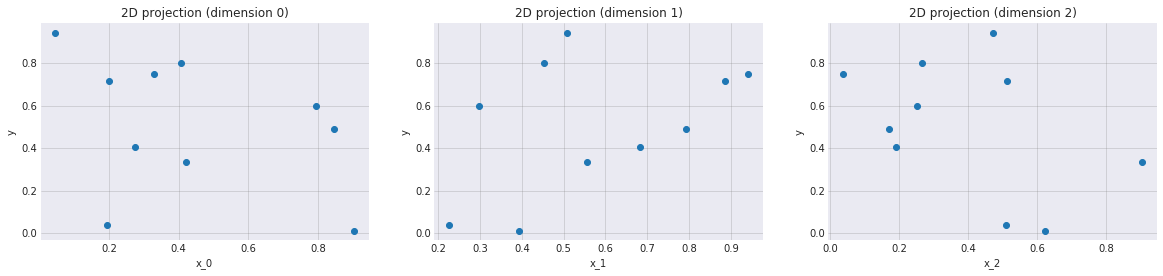

In [12]:
# create simulated dataset - RUN THIS CELL AS IS
np.random.seed(2019)
X = np.random.uniform(size = (10,9))
y = np.random.uniform(size = 10)

# plot the first 3 dimensions vs y
import helperFunc as hf
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4))
for i, ax in enumerate((ax1, ax2, ax3)):
    hf.plot2D(ax, X, y, xdim = i)

Each of the plots above represents 2D projection of this dataset (one of the x dimensions plotted with y).

> __DISCUSSION QUESTIONS:__  
 * _Examine the code that generates this dataset. How many dimensions does the data have? (feel free to add an extra cell to take a look at $X$ if you like)_ 
 * _Given what you observe in the plot and what you know about how the data were generated, how well would you expect a linear model to fit this data? what would it look like?_ 

The code below fits a regularized and unregularized model to the dataset generated above and plots a 2D view of the resulting models in the same projection as above.

OLS   coefficients: -0.47  0.34  -0.16  -0.76  0.82  0.91  1.04  0.62  -1.34
Ridge coefficients: -0.02  0.01  -0.01  0.0  -0.01  0.02  0.02  -0.01  -0.0


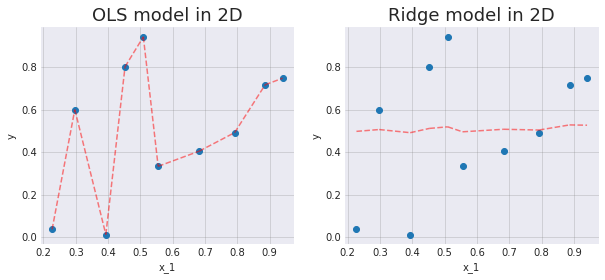

In [13]:
from sklearn.linear_model import LinearRegression, Ridge
import helperFunc as hf

#################### Demo Parameters #################### 
# TRY CHANGING THESE
REGULARIZATION_PARAMETER = 20
PROJECTION_DIMENSION = 1
nPOINTS = 10
nDim = 9

################### Penalized Loss Curves Demo #################### 
### data (same as above unless you change the number of points / dimensions)
np.random.seed(2019)
X = np.random.uniform(size = (nPOINTS,nDim))
y = np.random.uniform(size = nPOINTS)

### fit an OLS model and a ridge model using sklearn
ols = LinearRegression().fit(X,y)
ridge = Ridge(alpha = REGULARIZATION_PARAMETER).fit(X,y)

### print out the model parameters side by side
print('OLS   coefficients: ' + '  '.join([str(round(w,2)) for w in ols.coef_]))
print('Ridge coefficients: ' + '  '.join([str(round(w,2)) for w in ridge.coef_]))

### plot comparison in 2D
labels=['OLS model in 2D', 'Ridge model in 2D']
hf.compare2Dprojections(X, y, xdim = PROJECTION_DIMENSION, models = [ols, ridge], labels = labels)


> __DISCUSSION QUESTIONS:__  
 * _Compare the coefficients of the regularized & unregularized models. What do you notice? How does changing the regularization parameter affect the relationship between the OLS and Ridge coefficients_ 
 * _Given what you know about this dataset, is there anything surprising about the OLS model as plotted in the 2D projection? What might be going on here?_
 * _Compare the OLS and Ridge models based on their plots. Which model is overfitting?_
 * _Try a few different regularization parameter and projection dimensions... how does this affect the overfitting problem?_
 * _If time permits, try increasing the number of data points... how does this affect the overfitting problem?_
 
__Notes:__
* _This demo exercise was inspired by one of the examples presented in_ [these lecture notes by Wessel N. van Wieringen, VU University](https://www.statisticshowto.datasciencecentral.com/wp-content/uploads/2017/07/lecture-notes.pdf) _which the author has published under a creative commons license._
* _The sklearn package has very nice alternalte approach to illustrating how ridge regression reduces the variance of the linear model that gets fit. If time permits, check it out_ [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py).

__INSTRUCTOR TALKING POINTS__  
Key Points:
* L2 norm ("shrinkage") ~ reduce variance
* mitigate overfitting
* multi-colinearity problem (preview next section)
* interpretability problem (preview next section)

### Demo 4: Lasso Regression
Consider the following 10 point dataset.

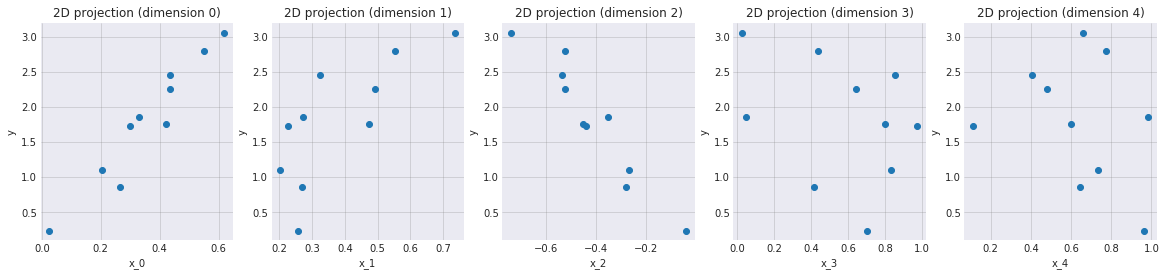

In [15]:
# create simulated dataset - RUN THIS CELL AS IS
np.random.seed(2)
N = 10
x0 = np.random.uniform(size = N)
x1 = x0 + np.random.normal(0,0.1,N)
x2 = - x0 + np.random.normal(0,0.1,N)
x3thru9 = np.random.uniform(size = (N,7))
X = np.hstack([np.array([x0,x1,x2]).T, x3thru9])
y = 5*x0 + np.random.normal(0,0.2,N)

# plot the first dimension vs y
import helperFunc as hf
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,4))
for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
    hf.plot2D(ax, X, y, xdim = i)

> __DISCUSSION QUESTIONS:__  
 * _Examine the code that generates this dataset. How many dimensions does the data have? (feel free to add an extra cell to take a look at $X$ if you like)_ 
 * _Given what you observe in the plot and what you know about how the data were generated, how many of the features (dimensions) are going to be helpful in creating a linear model? which ones?_
 * _Based on what you saw in the last demo, what are the risks associated with a model that includes all 5 features?_

The code below fits ols, ridge and lasso models to the dataset generated above. Use the code provided to explore the effects of lasso regularization. Can you identify the key difference between lasso and ridge?

OLS   coefficients: 10.87  -1.46  4.83  0.62  -0.8  0.33  -0.72  1.66  -0.24
Ridge coefficients: 1.74  1.57  -1.11  -0.17  -0.41  -0.14  -0.16  -0.01  0.12
Lasso coefficients: 2.02  0.06  -0.72  0.0  -0.0  -0.0  0.0  0.0  0.0


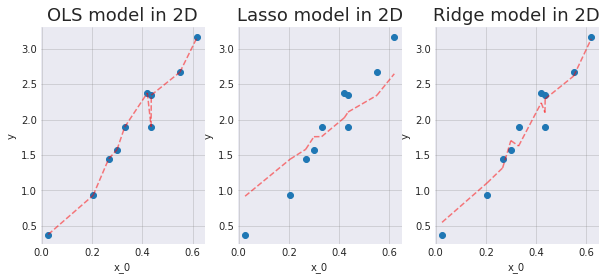

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import helperFunc as hf

#################### Demo Parameters #################### 
# TRY CHANGING THESE
REGULARIZATION_PARAMETER = 0.05
PROJECTION_DIMENSION = 0
nPOINTS = 10
nDim = 9

################### Penalized Loss Curves Demo #################### 
### data (same as above)
np.random.seed(2)
x0 = np.random.uniform(size = nPOINTS)
x1 = x0 + np.random.normal(0,0.1,nPOINTS)
x2 = - x0 + np.random.normal(0,0.1,nPOINTS)
x3thruN = np.random.uniform(size = (nPOINTS,nDim - 3))
X = np.hstack([np.array([x0,x1,x2]).T, x3thruN])
y = 5*x0 + np.random.normal(0,0.2,nPOINTS)

### fit an OLS model and a ridge model using sklearn
ols = LinearRegression().fit(X,y)
ridge = Ridge(alpha = REGULARIZATION_PARAMETER).fit(X,y)
lasso = Lasso(alpha = REGULARIZATION_PARAMETER).fit(X,y)

### print out the model parameters side by side
print('OLS   coefficients: ' + '  '.join([str(round(w,2)) for w in ols.coef_]))
print('Ridge coefficients: ' + '  '.join([str(round(w,2)) for w in ridge.coef_]))
print('Lasso coefficients: ' + '  '.join([str(round(w,2)) for w in lasso.coef_]))

### plot comparison in 2D
labels=['OLS model in 2D', 'Lasso model in 2D', 'Ridge model in 2D']
hf.compare2Dprojections(X, y, xdim = PROJECTION_DIMENSION, models = [ols, lasso, ridge], labels = labels)

> __DISCUSSION QUESTIONS:__  
 * _Examine the ols, lasso and ridge regression coefficients. How do these three models differ?_ 
 * _Based on the plots, does lasso seem like a better model? What might be the benefits to using lasso despite the seemingly worse fit?_
 * _Try changing the regularization parameter, what do you notice about the difference between "reasonable" looking regularization terms for ridge and lasso?_
 
 __Notes:__
 * _ISL is the best reference for understanding LASSO since Tibshirani was one of its main architects... however we also recommend the following_ [paper by Andrew Ng](https://icml.cc/Conferences/2004/proceedings/papers/354.pdf). _And these accompanying_ [lecture slides](http://cseweb.ucsd.edu/~elkan/254spring05/Hammon.pdf) _may also be of interest._

__INSTRUCTOR TALKING POINTS__  
Key Points
* extreme data dimension problem --> no closed form solution
* multi-colinearity problem revisited
* alternative to forward/backward selection
* less features = more interprable


# Converging Faster

Regularization addresses the issue of trying to make sure that our gradient descent will end up at a minimum point that represents a model that generalizes well. However we should also be concerned with optimizing the speed (i.e. number of steps/epochs/updates needed) at which GD converges. In general we do this by being spart about the learning rate.

#### Some Common Techniques (hacks?) to improve Gradient Descent's speed


1. __Slow down as we get closer to a minimum__ 
> _GD does this naturally because the magnitude of the update vector will get smaller as the slopes get shallower around a minimum, however we can help it along strategically by reducing lambda as we perceive that our traing updates are getting smaller._ (look up: "__Adagrad__", "__Adadelta", "__RMSprop__")

2. __Using momentum__ : 
> _Take bigger updates when the direction of the next update is similar to the last one._  (look up: "__Nesterov accelerated gradient__").

3. __Perform different size updates for each parameter__: 
> _This is particularly helpful for unnormalized data but can help in general as some of your parameters may not contribute much to improving the model performance_ (look up: "__Adam__" (adaptive moment estimation) and "__AdaMax__")

3. __Train each parameter independently__: 
> _This is a newer approach that has interesting implications for parallelized SGD._

The following image comes from this [article by Sebastian Ruder](http://ruder.io/optimizing-gradient-descent/) ([arxiv link])(https://arxiv.org/pdf/1609.04747.pdf) which is a good starting point if you want to dive into any of these GD variants more deeply.
![SaddlePoint](saddle_point_evaluation_optimizers.gif "gif")

# If all else fails

With more complicated Loss Functions we may run the risk of making a mistake when computing the gradient. In some cases it may even be impossible to compute an analytical gradient. In this section we'll look at a simple way to check that our gradient function is right. This "numerical approximation of the gradient" can be used as an alternative to perform gradient updates.

__(Numerical Approximation Method)__

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

The code below uses a dataset from sklearn to compare this approximation to the true gradient using a dataset from sklearn & some helper classes in an attached file.

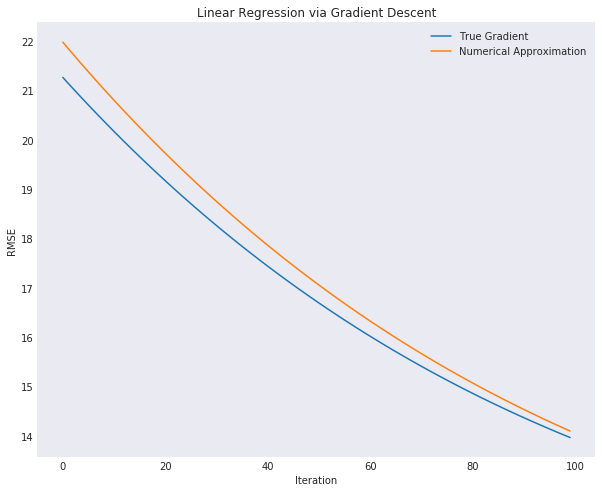

In [17]:
import homegrown as hg
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the data & take a look.
boston = load_boston()
#print(boston.DESCR) # -- uncomment to run

# Create data frame & test/train split.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create & fit models with & without numerical approximation
model_homegrown = hg.BasicLinearRegressionHomegrown()
model_homegrown.fit(X_train, y_train, max_iter=100, alpha=0.001)
model_homegrown_check_grad = hg.TweakedLinearRegressionHomegrown()
model_homegrown_check_grad.fit(X_train, y_train, max_iter=100, alpha=0.001)

# plot the training curve
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="True Gradient")
plt.plot(model_homegrown_check_grad.history["cost"], label="Numerical Approximation")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend()
plt.show()

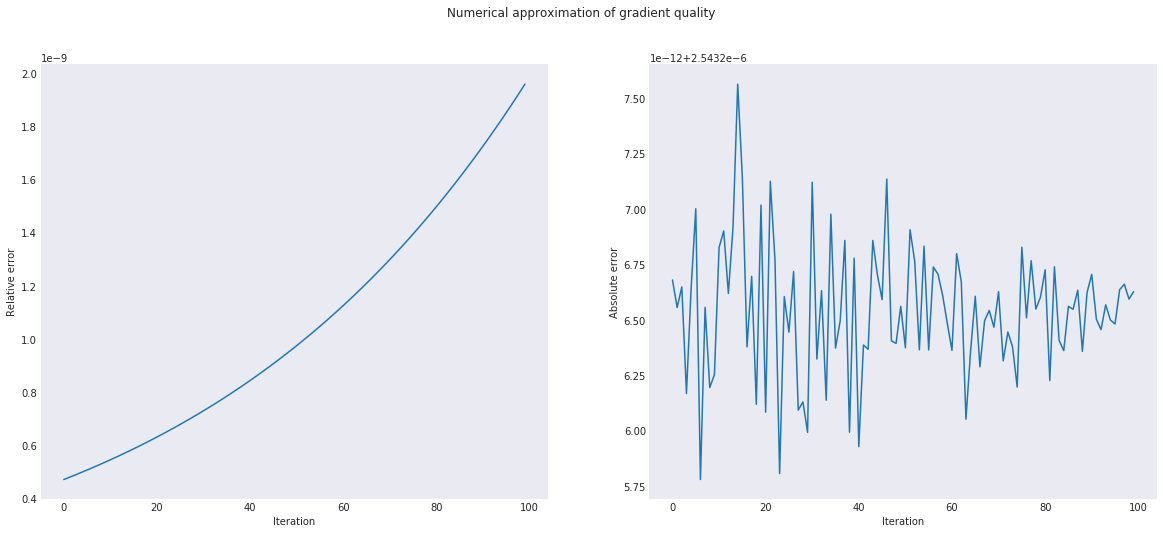

In [18]:
# compare the RMSE & gradients for all 100 iterations
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()